# Castañas

En este documento se va a crear un modelo para las castañas para su posterior análisis con XAI

## Carga de datos ya aumentados

In [2]:
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import numpy as np

In [19]:
dataset_dir = '/kaggle/input/castanas-aug-ds/castanas_aug_ds'

train, val = keras.utils.image_dataset_from_directory (
    directory=dataset_dir,
    batch_size=32,
    shuffle=True,
    labels="inferred" ,
    class_names= ["no_comible", "comible"],
    label_mode='binary',
    color_mode='rgb',
    image_size=(256,256),
    validation_split=0.2,
    subset='both',
    seed=69,
    )


Found 2186 files belonging to 2 classes.
Using 1749 files for training.
Using 437 files for validation.


In [4]:
def ver_imgs(dataset: tf.data.Dataset):
    clases = ['no comible', 'comible']
    plt.figure(figsize=(5,5))
    # plt.subplots_adjust(hspace=10)

    imgs, labels = next(iter(dataset.take(1)))

    for i in range(3):
        img, label = imgs[i], labels[i]
        ax = plt.subplot(1,3,i+1)
        ax.set_axis_off()
        plt.imshow( img.numpy().astype('uint8') )
        plt.title ( clases[int(label.numpy()[0])])


    plt.tight_layout()
    plt.show()
        

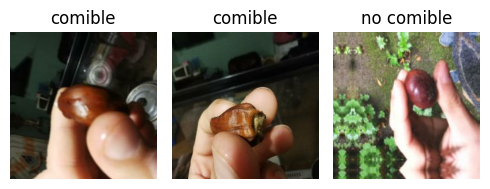

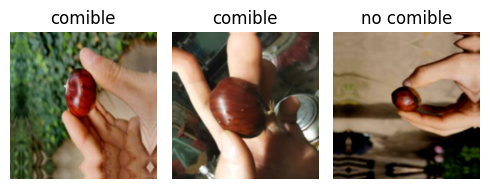

In [5]:
ver_imgs(train)
ver_imgs(val)

## hyper-parámetros

In [6]:
lr = 5e-5
batch_size = 32

## Modelo CNN

In [7]:
modificar_img = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
    keras.layers.RandomContrast(0.2)
])

In [8]:
def get_model(lr):
    model = keras.Sequential([
        keras.Input(shape=(256, 256, 3)),
        keras.layers.Rescaling(1./255),
        modificar_img, 
        #1
        #agregado kernel_regularizer=keras.regularizers.l2(0.001)
        keras.layers.Conv2D( filters=32, kernel_size=(5,5)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #2
        keras.layers.Conv2D( filters=64, kernel_size=(7,7)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #3
        keras.layers.Conv2D( filters=64, kernel_size=(3,3)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #4
        keras.layers.Conv2D( filters=64, kernel_size=(3,3)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
        #5
        keras.layers.Conv2D( filters=64, kernel_size=(3,3)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPool2D((2,2)),
        keras.layers.Dropout(0.2) ,
    
        #agregado drop 0.2->0.4, kernel_regularizer=keras.regularizers.l2(0.001)
        keras.layers.Flatten(),
        #1
        keras.layers.Dense(units= 128),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.4) ,
        #2
        keras.layers.Dense(units= 64),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.2) ,
        #3
        keras.layers.Dense(units= 32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dropout(0.2) ,
        keras.layers.Dense(units= 1, activation='sigmoid'),
    ],
    trainable=True,
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr ),
        # optimizer='adam',
        loss=keras.losses.binary_crossentropy,
        metrics=['accuracy'],
    )

    return model

In [ ]:
model_v = get_model(lr)
model_v.summary()

## Ecnontrar el LR inicial óptimo

In [19]:
!pip install git+https://github.com/surmenok/keras_lr_finder.git

  Cloning https://github.com/surmenok/keras_lr_finder.git to /tmp/pip-req-build-vw1l9nav
  Running command git clone --filter=blob:none --quiet https://github.com/surmenok/keras_lr_finder.git /tmp/pip-req-build-vw1l9nav
  Resolved https://github.com/surmenok/keras_lr_finder.git to commit 3c8fe719d7e3291a1f72ff8a9a1c51e9fc5d520b
  Preparing metadata (setup.py) ... done
  Created wheel for keras_lr_finder: filename=keras_lr_finder-0.1-py3-none-any.whl size=3990 sha256=f2e86a068c8119f692d07be7e110717ce19b6a3d2380d7e2eb61088b9810ee95
  Stored in directory: /tmp/pip-ephem-wheel-cache-6__qkvvq/wheels/9e/ac/1e/ebd55983037086a0a0388bbaa16ba9a88b4a5f99628113a97f
Successfully built keras_lr_finder


In [ ]:
from keras_lr_finder import LRFinder


X_train_list = []
y_train_list = []

for images, labels in train:
    X_train_list.append(images.numpy())
    y_train_list.append(labels.numpy())

# Convertir a arrays
x_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train,
               start_lr=1e-5, end_lr=1e-3,
               batch_size=32, epochs=10)
lr_finder.plot_loss()


In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

def get_data_subset(dataset, subset_ratio=0.2):
    """
    Extrae un subconjunto del tf.data.Dataset.
    """
    total_size = tf.data.experimental.cardinality(dataset).numpy()
    subset_size = int(total_size * subset_ratio)
    return dataset.take(subset_size)


def train_model(get_model, train_sub,val_sub, lr, epochs=10, batch_size=32):
    """
    Entrena un modelo por un número corto de épocas para evaluar el rendimiento de un learning rate.
    """
    model = get_model(lr)
    history = model.fit(
        train_sub,
        validation_data=val_sub,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        class_weight={0: 1.5, 1: 1.0},
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        ]
    )
    val_acc = history.history.get('val_accuracy', [0])
    val_loss = history.history.get('val_loss', [np.inf])
    auc_val_acc = np.trapz(val_acc)
    return {
        'lr': lr,
        'val_acc_max': max(val_acc),
        'val_loss_min': min(val_loss),
        'auc_val_acc': auc_val_acc
    }


def find_optimal_lr(train, val, get_model, lr_central=1e-3, delta_init=4e-5, delta_min=1e-6,
                    n_intervals=20, max_iter=5, subset_ratio=0.2, early_stop_eps=1e-3):
    """
    Algoritmo de búsqueda iterativa de learning rate basado en precisión de validación.
    """
    train_sub = get_data_subset(train, subset_ratio)
    val_sub = get_data_subset(val, subset_ratio)

    results = []
    delta = delta_init
    best_result = None

    for iteration in range(max_iter):
        log_lr_central = np.log10(lr_central)
        log_delta = np.log10(1 + delta / lr_central)
        log_lrs = np.linspace(log_lr_central - log_delta, log_lr_central + log_delta, n_intervals)
        lrs = np.power(10, log_lrs)

        iter_results = []
        print(f"🔁 Iteración {iteration+1} | Explorando entre {lrs[0]:.2e} y {lrs[-1]:.2e}")
        for lr in lrs:
            result = train_model(get_model, train_sub, val_sub, lr)
            iter_results.append(result)
            print(f"  LR={lr:.2e} | val_acc={result['val_acc_max']:.4f} | AUC={result['auc_val_acc']:.4f}")

        # Selección de mejor learning rate
        best_in_iter = max(iter_results, key=lambda r: r['val_acc_max'])
        results.extend(iter_results)

        if best_result is None or best_in_iter['val_acc_max'] > best_result['val_acc_max'] + early_stop_eps:
            best_result = best_in_iter
            lr_central = best_result['lr']
        else:
            print("📉 Mejora insignificante. Terminando búsqueda.")
            break

        # Condición de borde: si el mejor está al límite
        if np.isclose(lr_central, lrs[0]) or np.isclose(lr_central, lrs[-1]):
            delta *= 1.5
            print("🧭 Mejor LR está al borde. Expandiendo rango.")
        else:
            delta *= 0.5  # refinamiento

        if delta < delta_min:
            print("✅ Delta mínimo alcanzado.")
            break

    print(f"\n🏁 Mejor LR encontrado: {best_result['lr']:.2e} con val_acc={best_result['val_acc_max']:.4f}")
    return best_result, results


In [26]:
best_result, _ = find_optimal_lr(train, val, get_model)
lr_init = best_result['lr']

🔁 Iteración 1 | Explorando entre 6.67e-04 y 1.50e-03


E0000 00:00:1748207082.963719      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_16_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=6.67e-04 | val_acc=0.5938 | AUC=1.1172
  LR=6.96e-04 | val_acc=0.4844 | AUC=0.8672
  LR=7.26e-04 | val_acc=0.2500 | AUC=0.7500
  LR=7.58e-04 | val_acc=0.2500 | AUC=0.7500


E0000 00:00:1748207143.907339      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_7_1/dropout_48_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=7.91e-04 | val_acc=0.3125 | AUC=0.8203
  LR=8.25e-04 | val_acc=0.4531 | AUC=1.0859
  LR=8.61e-04 | val_acc=0.7344 | AUC=2.5000
  LR=8.99e-04 | val_acc=0.6719 | AUC=1.1094


E0000 00:00:1748207207.849754      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_11_1/dropout_80_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=9.38e-04 | val_acc=0.7031 | AUC=1.7578
  LR=9.79e-04 | val_acc=0.7500 | AUC=1.7891
  LR=1.02e-03 | val_acc=0.7344 | AUC=1.7266
  LR=1.07e-03 | val_acc=0.7344 | AUC=1.2578


E0000 00:00:1748207272.711583      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_15_1/dropout_112_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.11e-03 | val_acc=0.6094 | AUC=1.7109
  LR=1.16e-03 | val_acc=0.7969 | AUC=3.8984
  LR=1.21e-03 | val_acc=0.7500 | AUC=1.5938
  LR=1.26e-03 | val_acc=0.7500 | AUC=2.0078


E0000 00:00:1748207339.749942      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_19_1/dropout_144_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.32e-03 | val_acc=0.8125 | AUC=4.5312
  LR=1.38e-03 | val_acc=0.8125 | AUC=6.2109
  LR=1.44e-03 | val_acc=0.7656 | AUC=2.0391
  LR=1.50e-03 | val_acc=0.4844 | AUC=1.2188
🔁 Iteración 2 | Explorando entre 1.11e-03 y 1.57e-03


E0000 00:00:1748207412.861040      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_23_1/dropout_176_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.11e-03 | val_acc=0.6719 | AUC=1.7031
  LR=1.13e-03 | val_acc=0.7500 | AUC=1.4766
  LR=1.15e-03 | val_acc=0.7344 | AUC=1.6094
  LR=1.17e-03 | val_acc=0.7500 | AUC=1.2031


E0000 00:00:1748207476.105090      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_27_1/dropout_208_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.19e-03 | val_acc=0.6562 | AUC=2.7422
  LR=1.22e-03 | val_acc=0.7500 | AUC=1.7422
  LR=1.24e-03 | val_acc=0.5938 | AUC=0.9688
  LR=1.26e-03 | val_acc=0.6406 | AUC=2.5078


E0000 00:00:1748207543.302185      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_31_1/dropout_240_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.28e-03 | val_acc=0.7500 | AUC=2.1328
  LR=1.31e-03 | val_acc=0.7969 | AUC=3.6484
  LR=1.33e-03 | val_acc=0.7344 | AUC=1.3750
  LR=1.36e-03 | val_acc=0.7812 | AUC=2.2266


E0000 00:00:1748207609.713349      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_35_1/dropout_272_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.38e-03 | val_acc=0.7188 | AUC=2.1562
  LR=1.41e-03 | val_acc=0.7500 | AUC=2.3594
  LR=1.43e-03 | val_acc=0.7500 | AUC=2.1406
  LR=1.46e-03 | val_acc=0.7500 | AUC=3.7734


E0000 00:00:1748207677.703360      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_39_1/dropout_304_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.49e-03 | val_acc=0.7344 | AUC=2.2969
  LR=1.51e-03 | val_acc=0.7500 | AUC=2.5859
  LR=1.54e-03 | val_acc=0.7500 | AUC=1.6953
  LR=1.57e-03 | val_acc=0.8438 | AUC=6.7109
🧭 Mejor LR está al borde. Expandiendo rango.
🔁 Iteración 3 | Explorando entre 1.27e-03 y 1.94e-03


E0000 00:00:1748207751.435627      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_43_1/dropout_336_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.27e-03 | val_acc=0.5000 | AUC=2.2031
  LR=1.30e-03 | val_acc=0.7500 | AUC=2.2109
  LR=1.33e-03 | val_acc=0.7188 | AUC=2.7266
  LR=1.36e-03 | val_acc=0.7656 | AUC=5.0781


E0000 00:00:1748207829.329355      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_47_1/dropout_368_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.39e-03 | val_acc=0.7500 | AUC=2.8828
  LR=1.42e-03 | val_acc=0.7500 | AUC=1.9609
  LR=1.45e-03 | val_acc=0.7500 | AUC=2.5547
  LR=1.48e-03 | val_acc=0.6562 | AUC=1.8359


E0000 00:00:1748207894.837534      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_51_1/dropout_400_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.52e-03 | val_acc=0.7500 | AUC=2.0156
  LR=1.55e-03 | val_acc=0.7500 | AUC=2.9375
  LR=1.59e-03 | val_acc=0.7500 | AUC=2.2422
  LR=1.62e-03 | val_acc=0.7500 | AUC=2.2188


E0000 00:00:1748207956.691778      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_55_1/dropout_432_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.66e-03 | val_acc=0.8594 | AUC=6.8203
  LR=1.70e-03 | val_acc=0.7656 | AUC=2.2344
  LR=1.74e-03 | val_acc=0.7500 | AUC=2.2344
  LR=1.78e-03 | val_acc=0.7969 | AUC=4.9297


E0000 00:00:1748208030.085649      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_59_1/dropout_464_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.82e-03 | val_acc=0.7500 | AUC=4.4141
  LR=1.86e-03 | val_acc=0.7500 | AUC=2.2500
  LR=1.90e-03 | val_acc=0.7812 | AUC=4.6172
  LR=1.94e-03 | val_acc=0.8594 | AUC=6.8750
🔁 Iteración 4 | Explorando entre 1.49e-03 y 1.85e-03


E0000 00:00:1748208111.758544      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_63_1/dropout_496_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.49e-03 | val_acc=0.7656 | AUC=2.2109
  LR=1.51e-03 | val_acc=0.7500 | AUC=2.1328
  LR=1.53e-03 | val_acc=0.7500 | AUC=1.2812
  LR=1.54e-03 | val_acc=0.6875 | AUC=2.0703


E0000 00:00:1748208173.808860      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_67_1/dropout_528_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.56e-03 | val_acc=0.7500 | AUC=1.9531
  LR=1.58e-03 | val_acc=0.7500 | AUC=1.7891
  LR=1.60e-03 | val_acc=0.7656 | AUC=2.9297
  LR=1.61e-03 | val_acc=0.7188 | AUC=2.5156


E0000 00:00:1748208240.174650      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_71_1/dropout_560_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.63e-03 | val_acc=0.8438 | AUC=6.8203
  LR=1.65e-03 | val_acc=0.7500 | AUC=1.7344
  LR=1.67e-03 | val_acc=0.7812 | AUC=4.9062
  LR=1.69e-03 | val_acc=0.7500 | AUC=1.9922


E0000 00:00:1748208318.031283      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_75_1/dropout_592_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.71e-03 | val_acc=0.7188 | AUC=1.6172
  LR=1.73e-03 | val_acc=0.7812 | AUC=2.2656
  LR=1.75e-03 | val_acc=0.7500 | AUC=2.0938
  LR=1.77e-03 | val_acc=0.7656 | AUC=3.6250


E0000 00:00:1748208383.710820      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_79_1/dropout_624_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  LR=1.79e-03 | val_acc=0.7500 | AUC=2.2344
  LR=1.81e-03 | val_acc=0.7500 | AUC=2.2422
  LR=1.83e-03 | val_acc=0.7656 | AUC=3.6641
  LR=1.85e-03 | val_acc=0.7656 | AUC=2.2578
📉 Mejora insignificante. Terminando búsqueda.

🏁 Mejor LR encontrado: 1.66e-03 con val_acc=0.8594


({'lr': 0.001660758216205174,
  'val_acc_max': 0.859375,
  'val_loss_min': 0.362654447555542,
  'auc_val_acc': 6.8203125},
 [{'lr': 0.0006666666666666664,
   'val_acc_max': 0.59375,
   'val_loss_min': 0.6922907829284668,
   'auc_val_acc': 1.1171875},
  {'lr': 0.0006957362995396973,
   'val_acc_max': 0.484375,
   'val_loss_min': 0.6971770524978638,
   'auc_val_acc': 0.8671875},
  {'lr': 0.0007260734977457864,
   'val_acc_max': 0.25,
   'val_loss_min': 0.7170296907424927,
   'auc_val_acc': 0.75},
  {'lr': 0.0007577335327732473,
   'val_acc_max': 0.25,
   'val_loss_min': 0.7195606231689453,
   'auc_val_acc': 0.75},
  {'lr': 0.0007907740861932007,
   'val_acc_max': 0.3125,
   'val_loss_min': 0.7042886018753052,
   'auc_val_acc': 0.8203125},
  {'lr': 0.0008252553547499148,
   'val_acc_max': 0.453125,
   'val_loss_min': 0.6947431564331055,
   'auc_val_acc': 1.0859375},
  {'lr': 0.0008612401600335381,
   'val_acc_max': 0.734375,
   'val_loss_min': 0.6436508893966675,
   'auc_val_acc': 2.5},
 

## Ajustar LR dinámicamente

In [10]:
import math

class TriangularExponentialDecay(tf.keras.callbacks.Callback):
    # https://arxiv.org/abs/1506.01186?ref=jeremyjordan.me
    # https://www.jeremyjordan.me/nn-learning-rate/
    def __init__(self, max_lr, min_lr, steps_per_cycle, decay=0.9):
        super().__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.steps_per_cycle = steps_per_cycle
        self.decay = decay
        self.step = 0
        self.lr_history = []

    def on_train_batch_begin(self, batch, logs=None):
        cycle_position = self.step % self.steps_per_cycle
        cycle_fraction = cycle_position / self.steps_per_cycle

        if cycle_fraction <= 0.5:
            lr = self.min_lr + (self.max_lr - self.min_lr) * (cycle_fraction * 2)
        else:
            lr = self.max_lr - (self.max_lr - self.min_lr) * ((cycle_fraction - 0.5) * 2)

        # Apply exponential decay
        decay_factor = self.decay ** (self.step // self.steps_per_cycle)
        lr *= decay_factor

        self.model.optimizer.learning_rate.assign(lr)
        self.lr_history.append(lr)
        self.step += 1
        
    def plot(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.lr_history, label="Learning Rate")
        plt.xlabel("Training Step")
        plt.ylabel("Learning Rate")
        plt.title("Triangular Exponential Decay Schedule")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [12]:
# steps_per_epoch = cantidad de datos de entrenamiento // batch size
steps_per_epoch = 1749 // batch_size
dlr = 10
lr_n = 0.001660758216205174
scheduler_lr = TriangularExponentialDecay(
    # sin batch normalization
    # max_lr=5e-4, 
    # min_lr=4e-8, 
    max_lr=lr_n * (dlr/2) ,
    min_lr=lr_n * (1/dlr) , 
    # max_lr=5e-2,
    # min_lr=4e-9,
    steps_per_cycle=2 * steps_per_epoch,
    decay=0.8
)

# def scheduler(epoch, lr):
#     lr = 
#     lr = min(1e-2, lr)
#     lr = max(4e-04, lr)
    
# lr_sheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

## Early stopping

In [13]:
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 8,
    min_delta=0.001,
    restore_best_weights = True,
    )

## Entrenamiento

In [14]:
model = get_model(lr_n)

In [15]:
history = model.fit(
    train,
    epochs=40, 
    validation_data=val,
    callbacks = [early_stop, scheduler_lr],
    # callbacks = [early_stop],
    class_weight={0: 1.5, 1: 1.0},
)

Epoch 1/40


E0000 00:00:1748209860.678837      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1748209863.334867     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.6607 - loss: 0.7509 - val_accuracy: 0.7208 - val_loss: 3.9168
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.7956 - loss: 0.5455 - val_accuracy: 0.7208 - val_loss: 0.7123
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8611 - loss: 0.3827 - val_accuracy: 0.7437 - val_loss: 1.4544
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8732 - loss: 0.3577 - val_accuracy: 0.7300 - val_loss: 0.5456
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.9016 - loss: 0.2957 - val_accuracy: 0.3547 - val_loss: 3.7318
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8786 - loss: 0.3318 - val_accuracy: 0.4073 - val_loss: 2.0001
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.8962 - loss: 0.2930 - val_accuracy: 0.8993 - val_loss: 0.2252
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.8994 - loss: 0.2771 - val_accuracy: 0.7506 - val

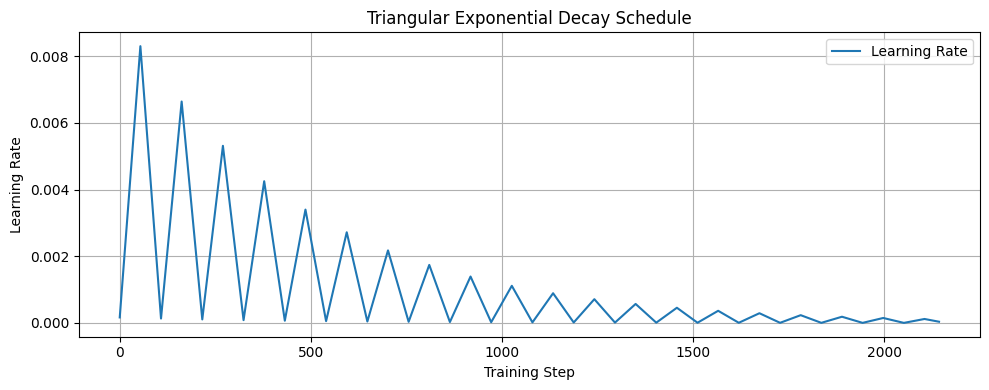

In [17]:
scheduler_lr.plot()

In [18]:
!mkdir -p "/kaggle/working/modelos/"
model.save("/kaggle/working/modelos/Castanas_Model_96.keras")

14/14 - 0s - 25ms/step - accuracy: 0.9588 - loss: 0.0989
val accuaricy: 0.9588100910186768 val loss: 0.09887080639600754


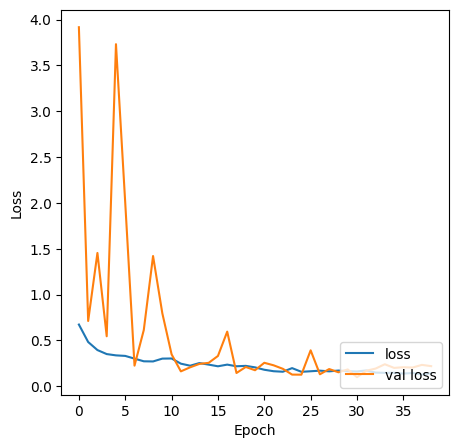

In [20]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

val_loss, val_acc = model.evaluate(val, verbose=2)
print(f'val accuaricy: {val_acc} val loss: {val_loss}')